In [1]:
import os
import sys
import json

import torch
import torch.nn as nn
from torchvision import transforms, datasets
import torch.optim as optim
from tqdm import tqdm

from model import vgg
from radam import RAdam
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
#from rmodel import resnet18


In [2]:
writer = SummaryWriter('logs')
# Initialize lists to store the training and validation loss rates
train_loss_list = []
val_acc_list = []

using cuda:0 device.
Using 8 dataloader workers every process
using 38076 images for training, 6718 images for validation.
train epoch[1/100] loss:0.491:   0%|          | 1/1190 [00:02<52:47,  2.66s/it]

/hy-tmp/2/radam.py:63: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1420.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)


100%|██████████| 210/210 [00:11<00:00, 18.14it/s]
[epoch 1] train_loss: 0.490  val_accuracy: 0.540
100%|██████████| 210/210 [00:11<00:00, 18.06it/s]
[epoch 2] train_loss: 0.490  val_accuracy: 0.498
100%|██████████| 210/210 [00:11<00:00, 18.27it/s]
[epoch 3] train_loss: 0.490  val_accuracy: 0.502
100%|██████████| 210/210 [00:11<00:00, 18.20it/s]
[epoch 4] train_loss: 0.490  val_accuracy: 0.505
100%|██████████| 210/210 [00:11<00:00, 18.25it/s]
[epoch 5] train_loss: 0.490  val_accuracy: 0.511
100%|██████████| 210/210 [00:11<00:00, 18.36it/s]
[epoch 6] train_loss: 0.489  val_accuracy: 0.564
100%|██████████| 210/210 [00:11<00:00, 17.99it/s]
[epoch 7] train_loss: 0.489  val_accuracy: 0.566
100%|██████████| 210/210 [00:11<00:00, 18.17it/s]
[epoch 8] train_loss: 0.488  val_accuracy: 0.538
100%|██████████| 210/210 [00:11<00:00, 18.20it/s]
[epoch 9] train_loss: 0.488  val_accuracy: 0.556
100%|██████████| 210/210 [00:11<00:00, 18.20it/s]
[epoch 10] train_loss: 0.486  val_accuracy: 0.564
100%|████

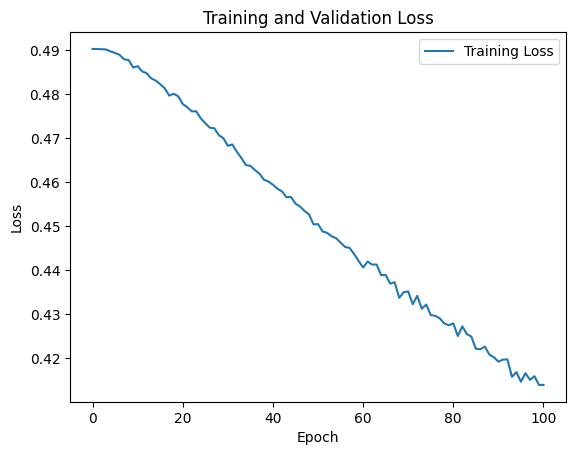

Finished Training


In [3]:
def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("using {} device.".format(device))

    data_transform = {
        "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
        "val": transforms.Compose([transforms.Resize((224, 224)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])}

    path="//hy-tmp//9yue//"
    image_path = os.path.join(path)  # flower data set path
    assert os.path.exists(image_path), "{} path does not exist.".format(image_path)
    train_dataset = datasets.ImageFolder(root=os.path.join(image_path+"train"),
                                         transform=data_transform["train"])
    train_num = len(train_dataset)

   
    flower_list = train_dataset.class_to_idx
    cla_dict = dict((val, key) for key, val in flower_list.items())
    # write dict into json file
    json_str = json.dumps(cla_dict, indent=4)
    with open('class_indices.json', 'w') as json_file:
        json_file.write(json_str)

    batch_size = 32
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
    print('Using {} dataloader workers every process'.format(nw))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size, shuffle=True,
                                               num_workers=nw)

    validate_dataset = datasets.ImageFolder(root=os.path.join(image_path,'val'),
                                            transform=data_transform["val"])
    val_num = len(validate_dataset)
    validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                                  batch_size=batch_size, shuffle=False,
                                                  num_workers=nw)
    print("using {} images for training, {} images for validation.".format(train_num,
                                                                           val_num))

    # test_data_iter = iter(validate_loader)
    # test_image, test_label = test_data_iter.next()

    model_name = "vgg13"
    net = vgg(model_name=model_name, num_classes=2, init_weights=True)
    net.to(device)
    
     #Define the loss function
    class FocalLoss(nn.Module):
        def __init__(self, gamma=0.5):
            super().__init__()
            self.gamma = gamma
    
        def forward(self, input, target):
            ce_loss = nn.CrossEntropyLoss(reduction='none')(input, target)
            pt = torch.exp(-ce_loss)
            focal_loss = (1 - pt) ** self.gamma * ce_loss
            return focal_loss.mean()
    
    loss_function = FocalLoss(gamma=0.5)
    
    # Define the optimizer and learning rate scheduler
    optimizer = RAdam(net.parameters(), lr=0.000005)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=3)
    
    #loss_function = nn.CrossEntropyLoss()
    #optimizer = optim.Adam(net.parameters(), lr=0.0001)

    epochs = 100
    best_acc = 0.0
    save_path = '//hy-tmp//pth//{}Net.pth'.format(model_name)
    train_steps = len(train_loader)
    for epoch in range(epochs):
        # train
        net.train()
        running_loss = 0.0
        train_bar = tqdm(train_loader, file=sys.stdout)
        for step, data in enumerate(train_bar):
            images, labels = data
            optimizer.zero_grad()
            outputs = net(images.to(device))
            loss = loss_function(outputs, labels.to(device))
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

            train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                     epochs,
                                                                     loss)

        # validate
        net.eval()
        acc = 0.0  # accumulate accurate number / epoch
        with torch.no_grad():
            val_bar = tqdm(validate_loader, file=sys.stdout)
            for val_data in val_bar:
                val_images, val_labels = val_data
                outputs = net(val_images.to(device))
                predict_y = torch.max(outputs, dim=1)[1]
                acc += torch.eq(predict_y, val_labels.to(device)).sum().item()

        val_accurate = acc / val_num
        #val_accurate = acc
        train_loss = running_loss / train_steps
        
        writer.add_scalar('Train/Loss', train_loss, global_step=epoch)
        writer.add_scalar('val_accurate', val_accurate, global_step=epoch)
    
        print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
              (epoch + 1, running_loss / train_steps, val_accurate))

        if val_accurate > best_acc:
            best_acc = val_accurate
            torch.save(net.state_dict(), save_path)
            
    # Compute the average loss and accuracy for this epoch
        epoch_loss = running_loss / train_steps
        epoch_acc = val_accurate
    # Append the results to the lists
        train_loss_list.append(epoch_loss)
        val_acc_list.append(epoch_acc)

# Compute the average loss and accuracy for this epoch
    epoch_loss = running_loss / train_steps
# Append the results to the lists
    train_loss_list.append(epoch_loss)
# Plot the training and validation loss rates
    plt.plot(train_loss_list, label='Training Loss')
# Add labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')

# Add legend
    plt.legend()

# Show the plot
    plt.show()    
# Append the results to the lists
    val_acc_list.append(epoch_acc)

# Plot the training and validation loss rates
    plt.plot(val_acc_list, label='val_accurate')

# Add labels and title
    plt.xlabel('Epoch')
    plt.ylabel('acc')
    plt.title('Validationacc')

# Add legend
    plt.legend()

# Show the plot
    plt.show()  
    print('Finished Training')


if __name__ == '__main__':
    main()